In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# --- Definisi state dan action ---
states = [
"Panas-Ada", "Nyaman-Ada", "Dingin-Ada",
"Panas-TidakAda", "Nyaman-TidakAda", "Dingin-TidakAda"
]
actions = ["Matikan", "Diam", "Nyalakan"]


state_size = len(states)
action_size = len(actions)


# --- Inisialisasi Q-Table ---
q_table = np.zeros((state_size, action_size))

In [2]:
# --- Hiperparameter ---
alpha = 0.9 # learning rate
gamma = 0.8 # discount factor
epsilon = 1.0 # eksplorasi awal
min_epsilon = 0.01
decay_rate = 0.005

In [8]:
# --- Lingkungan (sederhana) ---
def lingkungan_sederhana(state, state_index, action_index):
    suhu, hadir = state.split("-")
    action = actions[action_index]

    # default
    reward = -1
    next_state = state_index

    # logika transisi
    if suhu == "Panas" and hadir == "Ada":
        if action == "Nyalakan":
            next_state = states.index("Nyaman-Ada")
            reward = 10
        elif action == "Diam":
            next_state = state_index
            reward = -5
        else:  # Matikan
            next_state = states.index("Panas-Ada")
            reward = -10

    elif suhu == "Dingin" and hadir == "Ada":
        if action == "Matikan":
            next_state = states.index("Nyaman-Ada")
            reward = 10
        elif action == "Diam":
            next_state = state_index
            reward = -5
        else:  # Nyalakan
            next_state = states.index("Dingin-Ada")
            reward = -10

    elif suhu == "Nyaman" and hadir == "Ada":
        if action == "Diam":
            next_state = state_index
            reward = 5
        elif action == "Nyalakan":
            next_state = states.index("Dingin-Ada")
            reward = -10
        else:
            next_state = states.index("Panas-Ada")
            reward = -10

    # kondisi tidak ada orang -> penalti untuk pemborosan
    if hadir == "TidakAda":
        if action == "Nyalakan":
            reward = -5
        elif action == "Diam":
            reward = 2
        else:  # Matikan
            reward = 5

        # transisi sederhana: tanpa orang, suhu cenderung stabil
        if suhu == "Panas":
            next_state = states.index("Nyaman-TidakAda")
        elif suhu == "Dingin":
            next_state = states.index("Nyaman-TidakAda")
        else:
            next_state = state_index

    return next_state, reward

In [11]:
# --- Pelatihan ---
total_episodes = 10000
max_steps = 10
rewards_all_episodes = []

for episode in range(total_episodes):
    state = np.random.randint(0, state_size)
    rewards_current_episode = 0

    for step_num in range(max_steps):
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.randint(0, action_size)
        else:
            action = np.argmax(q_table[state, :])

        new_state, reward = lingkungan_sederhana(states[state], state, action)

        # update Q
        old_value = q_table[state, action]
        next_max = np.max(q_table[new_state, :])
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        state = new_state
        rewards_current_episode += reward

    # decay epsilon
    epsilon = min_epsilon + (1.0 - min_epsilon) * np.exp(-decay_rate * episode)
    rewards_all_episodes.append(rewards_current_episode)

Q-Table akhir:
                  Matikan  Diam  Nyalakan
Panas-Ada           14.0  19.0      30.0
Nyaman-Ada          14.0  25.0      14.0
Dingin-Ada          30.0  19.0      14.0
Panas-TidakAda      25.0  22.0      15.0
Nyaman-TidakAda     25.0  22.0      15.0
Dingin-TidakAda     25.0  22.0      15.0


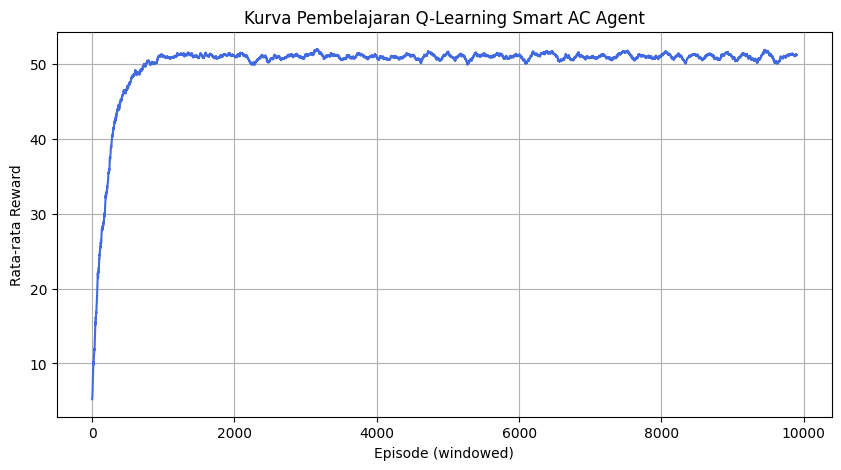

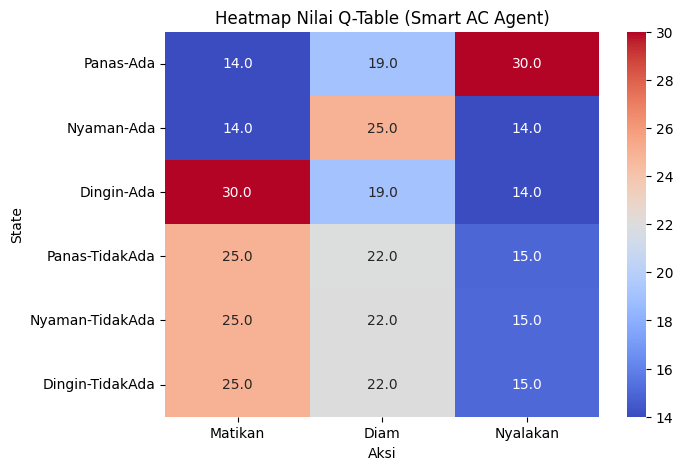


Kebijakan Optimal per State:

Panas-Ada          Nyalakan
Nyaman-Ada             Diam
Dingin-Ada          Matikan
Panas-TidakAda      Matikan
Nyaman-TidakAda     Matikan
Dingin-TidakAda     Matikan
dtype: object


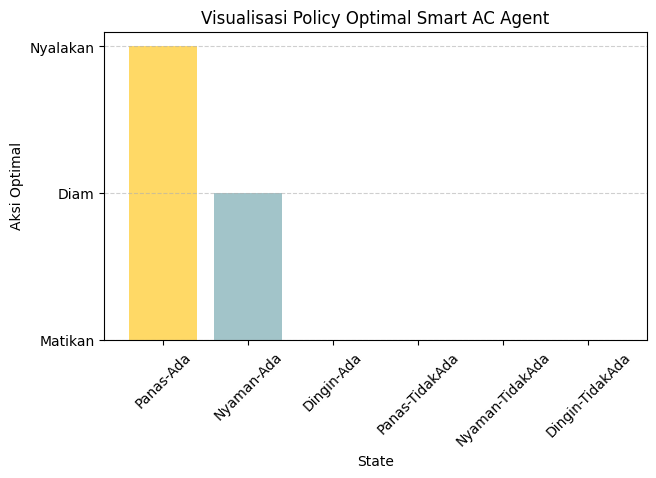

In [14]:
# --- Hasil ---
print("Q-Table akhir:\n", pd.DataFrame(q_table, index=states, columns=actions))

# Simpan Q-Table ke file CSV
q_df = pd.DataFrame(q_table, index=states, columns=actions)
q_df.to_csv('q_table_smart_ac.csv')

# --- Visualisasi 1: Kurva Pembelajaran (Reward vs Episode) ---
window = 100
moving_avg = np.convolve(rewards_all_episodes, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10,5))
plt.plot(moving_avg, color='royalblue')
plt.title('Kurva Pembelajaran Q-Learning Smart AC Agent')
plt.xlabel('Episode (windowed)')
plt.ylabel('Rata-rata Reward')
plt.grid(True)
plt.show()


# --- Visualisasi 2: Heatmap Q-Table ---
import seaborn as sns

plt.figure(figsize=(7,5))
sns.heatmap(q_df, annot=True, cmap="coolwarm", fmt=".1f")
plt.title("Heatmap Nilai Q-Table (Smart AC Agent)")
plt.xlabel("Aksi")
plt.ylabel("State")
plt.show()


# --- Visualisasi 3: Policy Map (Kebijakan Optimal) ---
policy = q_df.idxmax(axis=1)
print("\nKebijakan Optimal per State:\n")
print(policy)

# Visualisasi policy dengan warna berbeda per aksi
policy_colors = {
    "Nyalakan": "#FFD966",   # kuning
    "Diam": "#A2C4C9",       # biru muda
    "Matikan": "#B6D7A8"     # hijau muda
}

plt.figure(figsize=(7,4))
bars = plt.bar(policy.index, [actions.index(a) for a in policy], color=[policy_colors[a] for a in policy])
plt.xticks(rotation=45)
plt.yticks(range(len(actions)), actions)
plt.title("Visualisasi Policy Optimal Smart AC Agent")
plt.xlabel("State")
plt.ylabel("Aksi Optimal")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()



Strategi Kebijakan Optimal (Policy):
             State Aksi Optimal
0        Panas-Ada     Nyalakan
1       Nyaman-Ada         Diam
2       Dingin-Ada      Matikan
3   Panas-TidakAda      Matikan
4  Nyaman-TidakAda      Matikan
5  Dingin-TidakAda      Matikan


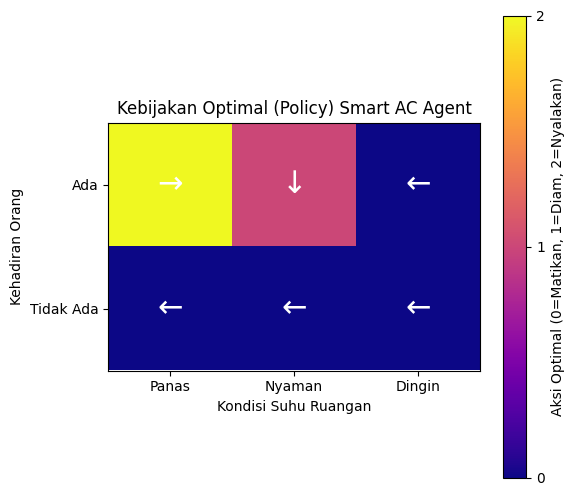

In [16]:
# --- Ambil aksi optimal dari setiap state ---
optimal_actions_index = np.argmax(q_table, axis=1)
policy = [actions[i] for i in optimal_actions_index]

# Buat DataFrame strategi kebijakan
df_policy = pd.DataFrame({
    "State": states,
    "Aksi Optimal": policy
})

print("\nStrategi Kebijakan Optimal (Policy):")
print(df_policy)

# --- Pemetaan aksi ke simbol arah (hanya untuk visualisasi) ---
arrow_map = {"Matikan": "←", "Diam": "↓", "Nyalakan": "→"}
arrow_symbols = [arrow_map[a] for a in policy]

# --- Visualisasi grid 2D (3 suhu × 2 kondisi kehadiran) ---
plt.figure(figsize=(6, 6))
plt.imshow(optimal_actions_index.reshape(2, 3), cmap='plasma')
plt.title("Kebijakan Optimal (Policy) Smart AC Agent")
plt.colorbar(ticks=range(3), label='Aksi Optimal (0=Matikan, 1=Diam, 2=Nyalakan)')

# Tambahkan simbol arah di setiap sel (mirip heatmap di modul aslinya)
for i in range(2):
    for j in range(3):
        idx = i * 3 + j
        plt.text(j, i, arrow_symbols[idx], ha='center', va='center', color='white', fontsize=22)

# Label sumbu
plt.xticks(range(3), ["Panas", "Nyaman", "Dingin"])
plt.yticks(range(2), ["Ada", "Tidak Ada"])
plt.xlabel("Kondisi Suhu Ruangan")
plt.ylabel("Kehadiran Orang")
plt.show()
